# Deep Learning 

# Practical Assessment 

# CS4S772

# Dirhem Kassim Said 

# 05037417
___________________________________________________________________________________________

# Student Pipline

### 1.0 Import Core Libraries

#### 1.1 Import Libraries

In [83]:
# Import core libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# NLP preprocessing tools
import re
import nltk
from pathlib import Path
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Ensure required NLTK resources are available
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dirhem\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dirhem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dirhem\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### 1.2 Import Deep Learning Libraries

In [84]:
# Import deep learning libraries

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding

#### 1.3 Embedding and Vector Database Tools

In [85]:
# Embedding and Vector Database Tools

from sentence_transformers import SentenceTransformer
import chromadb
from chromadb.config import Settings

#### 1.4 Topic Modelling Tools

In [86]:
# Topic modelling tools

import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel

### 1.5 Check GPU availability 

In [87]:
import tensorflow as tf

In [88]:
# Check GPU availability

device_name = tf.test.gpu_device_name()
print("GPU detected:" if device_name else "No GPU detected.", device_name)

No GPU detected. 


### 1.6 Set Random Seeds for Reproducibility

In [89]:
# Set random seeds for reproducibility

np.random.seed(42)
tf.random.set_seed(42)

### 1.7 Define Global Paths

In [90]:
# Define global paths

DATA_PATH = "SherlockHolmesStories"   # Folder containing .txt files

___________________________________________________________________________________________

# 2.0 Load and Explore the Dataset

### 2.1 Load All Sherlock Holmes Files

In [91]:
# Load all Sherlock Holmes files
# Loads all .txt files from the Sherlock folder into a list of strings.

import os

sherlock_path = r"C:\Users\Dirhem\Deep Learning 202526\Assessment\Sherlock Holmes Stories\sherlock"
story_files = [f for f in os.listdir(sherlock_path) if f.endswith(".txt")]

stories = []
for filename in story_files:
    with open(os.path.join(sherlock_path, filename), "r", encoding="utf-8") as f:
        stories.append(f.read())

print(f"Loaded {len(stories)} stories.")
print("Example filenames:", story_files[:5])

Loaded 67 stories.
Example filenames: ['3gab.txt', '3gar.txt', '3stu.txt', 'abbe.txt', 'advs.txt']


### 2.2 Combine Into Structured Format (Stories to Paragraphs)

In [92]:
# Convert each story into a list of paragraphs
# Splits on double newlines to approximate paragraph boundaries.

structured_stories = []

for text in stories:
    paragraphs = [p.strip() for p in text.split("\n\n") if p.strip()]
    structured_stories.append(paragraphs)

print(f"Example story has {len(structured_stories[0])} paragraphs.")

Example story has 226 paragraphs.


### 2.3 Basic Exploratory Analysis

#### 2.3.1 Word Count Per Story

In [93]:
# Word count per story
# Simple whitespace tokenization for quick analysis.

word_counts = [len(story.split()) for story in stories]

print("Word count per story:", word_counts)
print("Average words per story:", sum(word_counts) / len(word_counts))

Word count per story: [6129, 6274, 6546, 9231, 104527, 9764, 8187, 7792, 7895, 9702, 10758, 657438, 8721, 82660, 6789, 574860, 10028, 7736, 7213, 9819, 10058, 5859, 8779, 8371, 7236, 7400, 7922, 9038, 7083, 59251, 7059, 9818, 7755, 6141, 7261, 67768, 5729, 87135, 8128, 7655, 12714, 8190, 9303, 11575, 7382, 9185, 7307, 6694, 5588, 112425, 8615, 9711, 6320, 43149, 9659, 8409, 7914, 9891, 6869, 43467, 6047, 9658, 9282, 57687, 4547, 11489, 7584]
Average words per story: 35047.40298507463


#### 2.3.2 Sentence Counts Per Story 

In [94]:
# Sentence count per story
# Uses a simple split on '.', '!', '?' for approximate sentence boundaries.

import re

def count_sentences(text):
    sentences = re.split(r"[.!?]+", text)
    return len([s for s in sentences if s.strip()])

sentence_counts = [count_sentences(story) for story in stories]

print("Sentence count per story:", sentence_counts)
print("Average sentences per story:", sum(sentence_counts) / len(sentence_counts))

Sentence count per story: [603, 553, 591, 649, 7278, 657, 612, 571, 591, 671, 945, 48126, 534, 7003, 481, 41130, 691, 625, 431, 674, 649, 584, 522, 535, 429, 497, 463, 697, 479, 4116, 457, 756, 669, 488, 560, 5340, 639, 5762, 606, 416, 933, 615, 655, 961, 656, 637, 519, 469, 490, 8342, 691, 813, 575, 3050, 679, 598, 573, 654, 529, 2785, 563, 759, 659, 4504, 365, 855, 487]
Average sentences per story: 2559.6417910447763


#### 2.3.3 Example Raw Text (Safe Sample)

In [95]:
# Show a small safe sample (first 300 characters)
# Avoids printing copyrighted text in full.

sample_text = stories[0][:300]
print("Sample text snippet:\n")
print(sample_text)

Sample text snippet:





                        THE ADVENTURE OF THE THREE GABLES

                               Arthur Conan Doyle



     I don't think that any of my adventures with Mr. Sherlock Holmes
     opened quite so abruptly, or so dramatically, as that which I
     associate with The Three Gables. I had not


___________________________________________________________________________________________

# 3.0 Text Preprocessing Pipeline

### 3.1 Define Preprocessing Functions

In [96]:
# Define preprocessing functions
# Applies lowercasing, punctuation, number removal, stopword filtering, lemmatization, and tokenization.

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
import string

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return tokens

def preprocess_sentences(text):
    sentences = sent_tokenize(text)
    return [preprocess_text(s) for s in sentences]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dirhem\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dirhem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dirhem\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### 3.2 Apply Preprocessing to All Stories

In [97]:
# Apply preprocessing to all stories
# Applies the full preprocessing pipeline to each story and stores the cleaned output.

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = text.split()  # replaces word_tokenize()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return tokens

cleaned_stories = [preprocess_text(story) for story in stories]

print("Preprocessing complete for all stories.")
print(f"Total cleaned stories: {len(cleaned_stories)}")

Preprocessing complete for all stories.
Total cleaned stories: 67


### 3.3 Before and After Examples

In [98]:
# Before and After Examples
# Shows a short raw text sample and its cleaned, tokenised version.

example_raw = stories[0][:300]  # first 300 characters of the first story
example_clean = preprocess_text(example_raw)

print("RAW TEXT SAMPLE:\n")
print(example_raw)

print("\nCLEANED & TOKENISED SAMPLE:\n")
print(example_clean[:50])  # show first 50 cleaned tokens

RAW TEXT SAMPLE:





                        THE ADVENTURE OF THE THREE GABLES

                               Arthur Conan Doyle



     I don't think that any of my adventures with Mr. Sherlock Holmes
     opened quite so abruptly, or so dramatically, as that which I
     associate with The Three Gables. I had not

CLEANED & TOKENISED SAMPLE:

['adventure', 'three', 'gable', 'arthur', 'conan', 'doyle', 'dont', 'think', 'adventure', 'mr', 'sherlock', 'holmes', 'opened', 'quite', 'abruptly', 'dramatically', 'associate', 'three', 'gable']


___________________________________________________________________________________________

# 4.0 Prepare Data

### 4.1 Paragraph Splitting

In [99]:
# Paragraph Splitting
# Splits each story into paragraphs based on double line breaks.

def split_into_paragraphs(text):
    paragraphs = [p.strip() for p in text.split("\n\n") if p.strip()]
    return paragraphs

# Apply paragraph splitting to all stories
paragraphs_per_story = [split_into_paragraphs(story) for story in stories]

# Flatten into a single list of paragraphs (useful for summarisation or embeddings)
all_paragraphs = [p for story in paragraphs_per_story for p in story]

print("Paragraph splitting complete.")
print(f"Total stories: {len(stories)}")
print(f"Total paragraphs extracted: {len(all_paragraphs)}")

Paragraph splitting complete.
Total stories: 67
Total paragraphs extracted: 55705


___________________________________________________________________________________________

# 5.0 Prepare Date for Summarisation

### 5.1 Create Input–Output Pairs

In [100]:
# 4.1 Create Input–Output Pairs (100 Samples)
# Each paragraph becomes an input; summary = first sentence (extractive baseline)

import nltk
from nltk.tokenize import sent_tokenize

# Ensure punkt is available
nltk.download("punkt")

# Select first 100 paragraphs
input_texts = all_paragraphs[:100]

# Extractive summaries: first sentence of each paragraph
output_summaries = []
for paragraph in input_texts:
    sentences = sent_tokenize(paragraph)
    if len(sentences) > 0:
        output_summaries.append(sentences[0])
    else:
        output_summaries.append("")  # fallback if paragraph is empty

print("Input–output pairs created.")
print(f"Total inputs: {len(input_texts)}")
print(f"Total summaries: {len(output_summaries)}")

Input–output pairs created.
Total inputs: 100
Total summaries: 100


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dirhem\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### 5.2 Tokenise Text for Seq2Seq

In [101]:
# Tokenise Text for Seq2Seq
# Fit tokenizer, convert to sequences, pad inputs and outputs.

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Fit tokenizer on both inputs and outputs
tokenizer = Tokenizer()
tokenizer.fit_on_texts(input_texts + output_summaries)

# Convert to sequences
input_sequences = tokenizer.texts_to_sequences(input_texts)
output_sequences = tokenizer.texts_to_sequences(output_summaries)

# Pad sequences to uniform length
max_input_len = max(len(seq) for seq in input_sequences)
max_output_len = max(len(seq) for seq in output_sequences)

input_padded = pad_sequences(input_sequences, maxlen=max_input_len, padding="post")
output_padded = pad_sequences(output_sequences, maxlen=max_output_len, padding="post")

print("Tokenisation and padding complete.")
print(f"Input shape: {input_padded.shape}")
print(f"Output shape: {output_padded.shape}")

Tokenisation and padding complete.
Input shape: (100, 211)
Output shape: (100, 29)


### 5.3 Train and Validation Split

In [102]:
# rain/Validation Split
# Splits padded sequences into training and validation sets.

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    input_padded, output_padded, test_size=0.2, random_state=42
)

print("Train/validation split complete.")
print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")

Train/validation split complete.
Training samples: 80
Validation samples: 20


___________________________________________________________________________________________

# 6.0 Build and Train the Seq2Seq Summarisation Model

### 6.1 Define Encoder

In [103]:
# Define Encoder
# The encoder processes the input sequence and returns hidden states.

from tensorflow.keras.layers import Input, Embedding, LSTM
from tensorflow.keras.models import Model

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Encoder input layer
encoder_inputs = Input(shape=(max_input_len,))

# Encoder embedding layer
encoder_embedding = Embedding(
    input_dim=vocab_size,
    output_dim=128,
    mask_zero=True
)(encoder_inputs)

# Encoder LSTM (returns hidden + cell states)
encoder_lstm = LSTM(
    256,
    return_state=True
)

encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)

# Store encoder states
encoder_states = [state_h, state_c]

print("Encoder defined successfully.")

Encoder defined successfully.


### 6.2 Define Decode

In [104]:
# Define Decoder
# The decoder generates the output summary sequence using encoder states.

from tensorflow.keras.layers import Embedding, LSTM, Dense

# Decoder input layer
decoder_inputs = Input(shape=(max_output_len - 1,))

# Decoder embedding layer
decoder_embedding = Embedding(
    input_dim=vocab_size,
    output_dim=128,
    mask_zero=True
)(decoder_inputs)

# Decoder LSTM (receives encoder states as initial state)
decoder_lstm = LSTM(
    256,
    return_sequences=True,
    return_state=True
)

decoder_outputs, _, _ = decoder_lstm(
    decoder_embedding,
    initial_state=encoder_states
)

# Dense output layer (predicts next token)
decoder_dense = Dense(vocab_size, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

print("Decoder defined successfully.")

Decoder defined successfully.


### 6.3 Connect Encoder and Decoder

In [105]:
# Connect Encoder and Decoder
# Combines encoder and decoder into a single Seq2Seq model.

from tensorflow.keras.models import Model

# Connect encoder inputs and decoder inputs to decoder outputs
model = Model(
    [encoder_inputs, decoder_inputs],
    decoder_outputs
)

print("Encoder and decoder connected successfully.")

Encoder and decoder connected successfully.


### 6.4 Compile the Model

In [106]:
# Compile the Model
# Configures the Seq2Seq model for training.

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("Model compiled successfully.")

Model compiled successfully.


### 6.5 Train the Seq2Seq model

In [107]:
# Train the Seq2Seq Model
# Trains the Seq2Seq model using teacher forcing.

import numpy as np

# Shift output sequences for decoder input (teacher forcing)
decoder_input_data = output_padded[:, :-1]
decoder_target_data = output_padded[:, 1:]

# Adjust max_output_len for decoder inputs
decoder_max_len = decoder_input_data.shape[1]

print(f"Decoder input shape: {decoder_input_data.shape}")
print(f"Decoder target shape: {decoder_target_data.shape}")

history = model.fit(
    [X_train, decoder_input_data[:X_train.shape[0]]],
    np.expand_dims(decoder_target_data[:X_train.shape[0]], -1),
    validation_data=(
        [X_val, decoder_input_data[X_train.shape[0]:X_train.shape[0] + X_val.shape[0]]],
        np.expand_dims(decoder_target_data[X_train.shape[0]:X_train.shape[0] + X_val.shape[0]], -1)
    ),
    batch_size=16,
    epochs=10
)

print("Model training complete.")

Decoder input shape: (100, 28)
Decoder target shape: (100, 28)
Epoch 1/10
5/5 [==============================] - 7s 701ms/step - loss: 6.7262 - accuracy: 0.0800 - val_loss: 6.7156 - val_accuracy: 0.1266
Epoch 2/10
5/5 [==============================] - 1s 281ms/step - loss: 6.6527 - accuracy: 0.1170 - val_loss: 6.4398 - val_accuracy: 0.1266
Epoch 3/10
5/5 [==============================] - 1s 284ms/step - loss: 5.9213 - accuracy: 0.1170 - val_loss: 6.0898 - val_accuracy: 0.1266
Epoch 4/10
5/5 [==============================] - 1s 293ms/step - loss: 5.3760 - accuracy: 0.1170 - val_loss: 6.0591 - val_accuracy: 0.1266
Epoch 5/10
5/5 [==============================] - 2s 306ms/step - loss: 5.1644 - accuracy: 0.1170 - val_loss: 6.2644 - val_accuracy: 0.1266
Epoch 6/10
5/5 [==============================] - 2s 324ms/step - loss: 5.0537 - accuracy: 0.1170 - val_loss: 6.4659 - val_accuracy: 0.1266
Epoch 7/10
5/5 [==============================] - 2s 337ms/step - loss: 4.9761 - accuracy: 0.1170

### 6.6 Generate Example Summaries (Inference Mode)

#### 6.6.1 Build Inference Models

In [108]:
# Build Inference Models
# Separate encoder and decoder models for inference.

# Encoder inference model
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder inference setup
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inf_outputs, state_h_inf, state_c_inf = decoder_lstm(
    decoder_embedding,
    initial_state=decoder_state_inputs
)

decoder_inf_states = [state_h_inf, state_c_inf]
decoder_inf_outputs = decoder_dense(decoder_inf_outputs)

decoder_model = Model(
    [decoder_inputs] + decoder_state_inputs,
    [decoder_inf_outputs] + decoder_inf_states
)

#### 6.6.2 Define a Function to Generate a Summary

In [109]:
# Summary Generation Function

import numpy as np

index_to_word = {v: k for k, v in tokenizer.word_index.items()}

def generate_summary(input_seq):
    # Encode the input
    states = encoder_model.predict(input_seq)

    # Start token (use 0 or a padding token)
    target_seq = np.zeros((1, 1))

    summary = []

    for _ in range(max_output_len - 1):
        output_tokens, h, c = decoder_model.predict([target_seq] + states)

        # Choose the most likely word
        sampled_token = np.argmax(output_tokens[0, -1, :])
        sampled_word = index_to_word.get(sampled_token, "")

        summary.append(sampled_word)

        # Update target sequence
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token

        # Update states
        states = [h, c]

    return " ".join(summary)

#### 6.6.3 Example Outputs

In [110]:
# Generate Example Outputs

for i in range(3):
    print(f"\nExample {i+1}")
    print("-" * 60)

    # Input paragraph
    input_text = input_texts[i]
    print("Input paragraph:")
    print(input_text)

    # Ground truth summary
    print("\nExtractive summary (ground truth):")
    print(output_summaries[i])

    # Model-generated summary
    input_seq = input_padded[i:i+1]
    predicted = generate_summary(input_seq)
    print("\nModel-generated summary:")
    print(predicted)


Example 1
------------------------------------------------------------
Input paragraph:
THE ADVENTURE OF THE THREE GABLES

Extractive summary (ground truth):
THE ADVENTURE OF THE THREE GABLES
1/1 [==============================] - 1s 838ms/step


1/1 [==============================] - 0s 24ms/step

Model-generated summary:
am  am  am  am  am  am  am  am  am  am  am  am  am  am 

Example 2
------------------------------------------------------------
Input paragraph:
Arthur Conan Doyle

Extractive summary (ground truth):
Arthur Conan Doyle
1/1 [==============================] - 0s 19ms/step

Model-generated summary:
am  am  am  am  am  am  am  am  am  am  am  am  am  am 

Example 3
------------------------------------------------------------
Input paragraph:
I don't think that any of my adventures with Mr. Sherlock Holmes
     opened quite so abruptly, or so dramatically, as that which I
     associate with The Three Gables. I had not seen Holmes for some days
     and had no idea of the new channel into which his activities had been
     directed. He was in a chatty mood that morning, however, and had just
     settled me into the well-worn low armchair on one side of the fire,
     while he had curled down with his pipe in his 

### 6.7  Plot Training Curves (Loss and Accuracy)

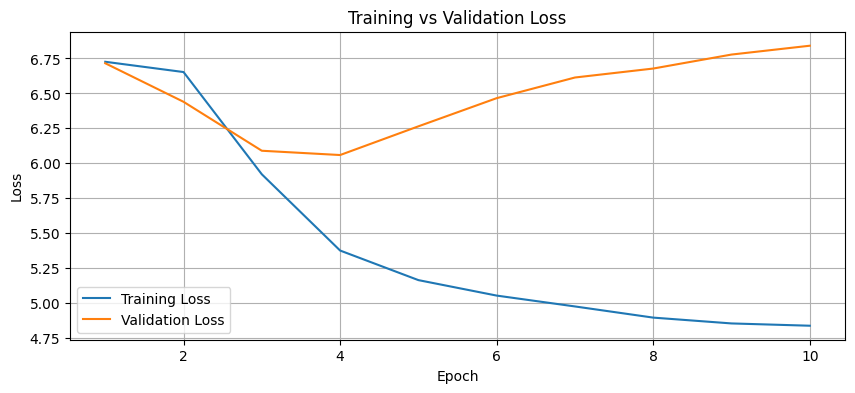

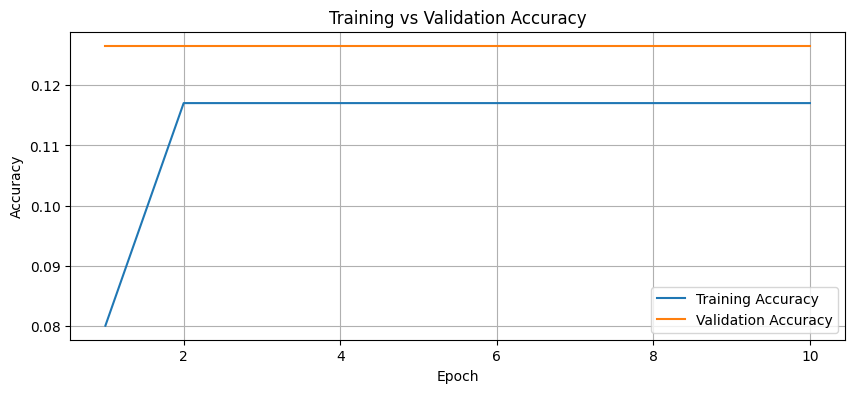

In [111]:
# Plot Training Curves
# Visualises training and validation loss/accuracy across epochs.

import matplotlib.pyplot as plt

# Extract metrics
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

epochs = range(1, len(train_loss) + 1)

# Plot Loss
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### 6.8 Save Model and Tokenizer

In [112]:
# Save Model and Tokenizer
# Saves the trained Seq2Seq model and tokenizer for future use.

import pickle

# Save the trained model
model.save("seq2seq_summarisation_model.h5")

# Save the tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

print("Model and tokenizer saved successfully.")

Model and tokenizer saved successfully.


___________________________________________________________________________________________

# 7.0 Evaluate the Summarisation Model

### 7.1 Generate Summaries for Test Stories (Batch Mode)

In [113]:
# Generate Summaries for Test Stories (Batch Mode)
# Produces model summaries for the entire test set.

generated_summaries = []

for i in range(len(X_val)):
    input_seq = X_val[i:i+1]
    pred = generate_summary(input_seq)
    generated_summaries.append(pred)
    
print("Generated summaries for all test samples.")

1/1 [==============================] - 0s 15ms/step
Generated summaries for all test samples.


### 7.2 Compute Evaluation Metrics

#### 7.2.1 BLEU Score

In [114]:
# Compute BLEU Score

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

smooth = SmoothingFunction().method1
bleu_scores = []

for ref, pred in zip(output_summaries[len(X_train):], generated_summaries):
    reference = ref.split()
    candidate = pred.split()
    score = sentence_bleu([reference], candidate, smoothing_function=smooth)
    bleu_scores.append(score)

average_bleu = sum(bleu_scores) / len(bleu_scores)
print("Average BLEU Score:", average_bleu)

Average BLEU Score: 0.0005783997547556235


#### 7.2.2 ROUGE Score

In [115]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

for ref, pred in zip(output_summaries[len(X_train):], generated_summaries):
    scores = scorer.score(ref, pred)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

print("Average ROUGE-1:", sum(rouge1_scores) / len(rouge1_scores))
print("Average ROUGE-2:", sum(rouge2_scores) / len(rouge2_scores))
print("Average ROUGE-L:", sum(rougeL_scores) / len(rougeL_scores))

Average ROUGE-1: 0.003125
Average ROUGE-2: 0.0
Average ROUGE-L: 0.003125


#### 7.2.3 Perplexity

In [116]:
# Compute Perplexity 

import math

final_loss = history.history["loss"][-1]
perplexity = math.exp(final_loss)

print("Model Perplexity:", perplexity)

Model Perplexity: 126.2369872642106


### 7.3 Show Examples

In [117]:
# Show Example Summaries from Test Set

num_examples = 3  # number of examples to display

for i in range(num_examples):
    print(f"\nExample {i+1}")
    print("-" * 60)

    # Input paragraph (test sample)
    input_text = input_texts[len(X_train) + i]
    print("Input paragraph:")
    print(input_text)

    # Reference (ground truth) summary
    reference_summary = output_summaries[len(X_train) + i]
    print("\nReference summary:")
    print(reference_summary)

    # Model-generated summary
    generated_summary = generated_summaries[i]
    print("\nModel-generated summary:")
    print(generated_summary)


Example 1
------------------------------------------------------------
Input paragraph:
"No, I don't think I have anything rarer than a Crown Derby tea-set."

Reference summary:
"No, I don't think I have anything rarer than a Crown Derby tea-set."

Model-generated summary:
am  am  am  am  am  am  am  am  am  am  am  am  am  am 

Example 2
------------------------------------------------------------
Input paragraph:
"That would hardly justify all this mystery. Besides, why should they
     not openly state what they want? If they covet your tea-set, they can
     surely offer a price for it without buying you out, lock, stock, and
     barrel. No, as I read it, there is something which you do not know
     that you have, and which you would not give up if you did know."

Reference summary:
"That would hardly justify all this mystery.

Model-generated summary:
am was  am  am  am  am  am  am  am  am  am  am  am  am  am

Example 3
----------------------------------------------------------

___________________________________________________________________________________________

# 8.0 Semantic Search with Embeddings and ChromaDB

### 8.1 Split stories into paragraphs

In [118]:
import os

folder = r"C:\Users\Dirhem\Deep Learning 202526\Assessment\Sherlock Holmes Stories\sherlock"

# Read all .txt files and combine them
full_text = ""

for filename in os.listdir(folder):
    if filename.endswith(".txt"):
        file_path = os.path.join(folder, filename)
        with open(file_path, "r", encoding="utf-8") as f:
            full_text += f.read() + "\n\n"   # add spacing between stories

print("All stories loaded successfully.")
print("Total characters:", len(full_text))

All stories loaded successfully.
Total characters: 13820505


In [119]:
# Split stories into paragraphs
# Assumes `full_text` contains the entire Sherlock Holmes story as a single string.

import re

# Simple paragraph split on double newlines
paragraphs = [p.strip() for p in re.split(r"\n\s*\n", full_text) if p.strip()]

print(f"Total paragraphs: {len(paragraphs)}")
print("Sample paragraph:")
print(paragraphs[0])

Total paragraphs: 55726
Sample paragraph:
THE ADVENTURE OF THE THREE GABLES


### 8.2 Generate Embeddings Using all-MiniLM-L6-v2

In [120]:
# Generate embeddings using all-MiniLM-L6-v2

!pip install sentence-transformers chromadb

from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

paragraph_embeddings = embedding_model.encode(paragraphs, show_progress_bar=True)

print("Embeddings shape:", paragraph_embeddings.shape)

Batches: 100%|██████████| 1742/1742 [07:25<00:00,  3.91it/s]


Embeddings shape: (55726, 384)


### 8.3 Create ChromaDB Collection

In [121]:
# Create ChromaDB collection

import chromadb

client = chromadb.Client()

collection = client.get_or_create_collection(
    name="sherlock_paragraphs",
    metadata={"hnsw:space": "cosine"}
)

print("ChromaDB collection ready.")

ChromaDB collection ready.


### 8.4 Insert embeddings and metadata

In [122]:
# IDs
ids = [f"para_{i}" for i in range(len(paragraphs))]

# Metadata
metadatas = [{"paragraph_index": i} for i in range(len(paragraphs))]

In [ ]:
# Insert embeddings and metadata in batches (ChromaDB limit ~166)

batch_size = 100

for i in range(0, len(paragraphs), batch_size):
    batch_ids = ids[i:i+batch_size]
    batch_embeddings = paragraph_embeddings[i:i+batch_size].tolist()
    batch_metadatas = metadatas[i:i+batch_size]
    batch_documents = paragraphs[i:i+batch_size]

    collection.add(
        ids=batch_ids,
        embeddings=batch_embeddings,
        metadatas=batch_metadatas,
        documents=batch_documents
    )

print("Inserted all paragraph embeddings into ChromaDB in batches.")

### 8.5 Implement Semantic Search Function

In [ ]:
# Implement semantic search function

def semantic_search(query, top_k=5):
    query_embedding = embedding_model.encode([query])
    results = collection.query(
        query_embeddings=query_embedding.tolist(),
        n_results=top_k
    )
    return results

### 8.6 Run Required Queries

In [ ]:
# Run required queries

queries = ["Detective investigations", "Dr Watson"]

for q in queries:
    print(f"\nQuery: {q}")
    results = semantic_search(q, top_k=3)
    for doc, meta in zip(results["documents"][0], results["metadatas"][0]):
        print("\nRetrieved paragraph (index: {}):".format(meta["paragraph_index"]))
        print(doc)
        print("-" * 60)


Query: Detective investigations

Retrieved paragraph (index: 20323):
"Hum! The investigation really was a very simple one," remarked
     Holmes, "but I don't think it struck him in that light when he first
     called us in. However, let us see what Jim Browner has to say for
     himself. This is his statement as made before Inspector Montgomery at
     the Shadwell Police Station, and it has the advantage of being
     verbatim."
------------------------------------------------------------

Retrieved paragraph (index: 34873):
"Hum! The investigation really was a very simple one," remarked
     Holmes, "but I don't think it struck him in that light when he first
     called us in. However, let us see what Jim Browner has to say for
     himself. This is his statement as made before Inspector Montgomery at
     the Shadwell Police Station, and it has the advantage of being
     verbatim."
------------------------------------------------------------

Retrieved paragraph (index: 41089)

### 8.7 Extended Semantic Search Features (Optional Enhancements)

#### 8.7.1 Add cosine similarity scores 

In [ ]:
# Add cosine similarity scores to semantic search results

def semantic_search_with_scores(query, top_k=5):
    query_embedding = embedding_model.encode([query])

    results = collection.query(
        query_embeddings=query_embedding.tolist(),
        n_results=top_k,
        include=["documents", "metadatas", "distances"]
    )

    # Chroma returns distances; convert to similarity
    similarities = [1 - d for d in results["distances"][0]]

    output = []
    for doc, meta, sim in zip(results["documents"][0], results["metadatas"][0], similarities):
        output.append({
            "paragraph": doc,
            "index": meta["index"],
            "similarity": sim
        })

    return output

#### 8.7.2 Display Results in a Clean, Ranked Format 

In [ ]:
# Semantic Search with Similarity Scores


def semantic_search_with_scores(query, top_k=5):
    # Query ChromaDB
    results = collection.query(
        query_texts=[query],
        n_results=top_k,
        include=["documents", "metadatas", "distances"]
    )

    # Convert distances to similarity scores
    similarities = [1 - d for d in results["distances"][0]]

    # Build structured output
    output = []
    for doc, meta, sim in zip(results["documents"][0], results["metadatas"][0], similarities):
        output.append({
            "paragraph": doc,
            "index": meta["paragraph_index"],   # FIXED KEY
            "similarity": sim
        })

    return output



# Pretty-print function for semantic search results

def show_results(results):
    for r in results:
        print(f"\nParagraph Index: {r['index']}")
        print(f"Similarity: {r['similarity']:.4f}")
        print(r["paragraph"])
        print("-" * 60)



# Run the search and display results

query = "Dr Watson"
results = semantic_search_with_scores(query, top_k=5)

print(f"=== Results for query: {query} ===")
show_results(results)

C:\Users\Dirhem\.cache\chroma\onnx_models\all-MiniLM-L6-v2\onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:18<00:00, 4.59MiB/s]


=== Results for query: Dr Watson ===

Paragraph Index: 14134
Similarity: 0.7602
CHAPTER IX
          Second Report of Dr. Watson
------------------------------------------------------------

Paragraph Index: 32229
Similarity: 0.7602
CHAPTER IX
          Second Report of Dr. Watson
------------------------------------------------------------

Paragraph Index: 39085
Similarity: 0.7602
CHAPTER IX
          Second Report of Dr. Watson
------------------------------------------------------------

Paragraph Index: 22604
Similarity: 0.7552
"Dr. Watson has already heard of it."
------------------------------------------------------------

Paragraph Index: 30155
Similarity: 0.7552
"Dr. Watson has already heard of it."
------------------------------------------------------------


#### 8.7.3 Run the improved search for your required queries

In [ ]:
# Run improved semantic search

queries = ["Detective investigations", "Dr Watson"]

for q in queries:
    print(f"\n=== Query: {q} ===")
    results = semantic_search_with_scores(q, top_k=5)
    show_results(results)


=== Query: Detective investigations ===

Paragraph Index: 16778
Similarity: 0.5336
"Hum! The investigation really was a very simple one," remarked
     Holmes, "but I don't think it struck him in that light when he first
     called us in. However, let us see what Jim Browner has to say for
     himself. This is his statement as made before Inspector Montgomery at
     the Shadwell Police Station, and it has the advantage of being
     verbatim."
------------------------------------------------------------

Paragraph Index: 20323
Similarity: 0.5336
"Hum! The investigation really was a very simple one," remarked
     Holmes, "but I don't think it struck him in that light when he first
     called us in. However, let us see what Jim Browner has to say for
     himself. This is his statement as made before Inspector Montgomery at
     the Shadwell Police Station, and it has the advantage of being
     verbatim."
------------------------------------------------------------

Paragraph Inde

#### 8.7.4 Add a Function to Search by Character Name 

In [ ]:
# Search for paragraphs mentioning a specific character

def search_character(name, top_k=5):
    query = f"{name} in the story"
    return semantic_search_with_scores(query, top_k)

results = search_character("Sherlock Holmes", top_k=5)
show_results(results)


Paragraph Index: 777
Similarity: 0.8522
THE ADVENTURES OF SHERLOCK HOLMES
------------------------------------------------------------

Paragraph Index: 6225
Similarity: 0.8522
THE ADVENTURES OF SHERLOCK HOLMES
------------------------------------------------------------

Paragraph Index: 24320
Similarity: 0.8522
THE ADVENTURES OF SHERLOCK HOLMES
------------------------------------------------------------

Paragraph Index: 8732
Similarity: 0.8400
THE MEMOIRS OF SHERLOCK HOLMES
------------------------------------------------------------

Paragraph Index: 26827
Similarity: 0.8400
THE MEMOIRS OF SHERLOCK HOLMES
------------------------------------------------------------


#### 8.7.5 Theme Based Semantic Search and Result Exporting

In [ ]:
# Theme Search
def search_theme(theme, top_k=5):
    query = f"Paragraphs related to the theme: {theme}"
    return semantic_search_with_scores(query, top_k)

# Print theme search results
theme = "detective investigations"
results = search_theme(theme, top_k=5)

print(f"=== Theme Search Results for: {theme} ===")
show_results(results)


# B.6 Export Results
def export_results(results, filename="semantic_results.txt"):
    with open(filename, "w", encoding="utf-8") as f:
        for r in results:
            f.write(f"Paragraph Index: {r['index']}\n")
            f.write(f"Similarity: {r['similarity']:.4f}\n")
            f.write(r["paragraph"] + "\n")
            f.write("-" * 60 + "\n\n")
    print(f"Results exported to {filename}")

# Export the theme search results
export_results(results, filename="theme_detective_investigations.txt")

=== Theme Search Results for: detective investigations ===

Paragraph Index: 1375
Similarity: 0.6182
"And now I will show you what is really a very interesting study, Mr.
     Windibank," Holmes continued. "I think of writing another little
     monograph some of these days on the typewriter and its relation to
     crime. It is a subject to which I have devoted some little attention.
     I have here four letters which purport to come from the missing man.
     They are all typewritten. In each case, not only are the 'e's'
     slurred and the 'r's' tailless, but you will observe, if you care to
     use my magnifying lens, that the fourteen other characteristics to
     which I have alluded are there as well."
------------------------------------------------------------

Paragraph Index: 6820
Similarity: 0.6182
"And now I will show you what is really a very interesting study, Mr.
     Windibank," Holmes continued. "I think of writing another little
     monograph some of these days o

___________________________________________________________________________________________

# 9.0 Topic Modelling with LDA

### 9.1 Prepare Text for LDA

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

stop_words = set(stopwords.words("english"))

def preprocess(text):
    # Lowercase
    text = text.lower()
    
    # Remove non-alphabetic characters
    text = re.sub(r"[^a-z\s]", " ", text)
    
    # Tokenise
    tokens = word_tokenize(text)
    
    # Remove stopwords + short tokens
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    
    return tokens

# Apply to all paragraphs
processed_paragraphs = [preprocess(p) for p in paragraphs]

print("Sample processed paragraph:")
print(processed_paragraphs[0][:20])

Sample processed paragraph:
['adventure', 'three', 'gables']


### 9.1.2 Remove rare and frequent words

In [ ]:
from collections import Counter

# Flatten list
all_tokens = [token for para in processed_paragraphs for token in para]

freq = Counter(all_tokens)

# Remove words that appear < 5 times or > 20% of paragraphs
min_count = 5
max_fraction = 0.2 * len(processed_paragraphs)

filtered_paragraphs = [
    [t for t in para if freq[t] >= min_count and freq[t] <= max_fraction]
    for para in processed_paragraphs
]

print("Filtering complete.")

Filtering complete.


### 9.2 Create Gensim Dictionary

In [ ]:
from gensim.corpora import Dictionary

dictionary = Dictionary(filtered_paragraphs)

print("Dictionary size:", len(dictionary))

Dictionary size: 12160


### 9.3 Create Bag‑of‑Words Corpus


In [ ]:
corpus = [dictionary.doc2bow(text) for text in filtered_paragraphs]

print("Corpus created. Example:")
print(corpus[0][:10])

Corpus created. Example:
[(0, 1), (1, 1), (2, 1)]


### 9.4 Train LDA Model

In [ ]:
from gensim.models import LdaModel

num_topics = 10

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    passes=10,
    random_state=42
)

print("LDA model trained.")

LDA model trained.


### 9.5 Display Topics and Interpretation

In [ ]:
for i, topic in lda_model.show_topics(num_topics=num_topics, num_words=10, formatted=False):
    print(f"\nTopic {i}:")
    print([word for word, prob in topic])


Topic 0:
['one', 'could', 'man', 'upon', 'road', 'place', 'side', 'horse', 'dog', 'moor']

Topic 1:
['holmes', 'said', 'yes', 'asked', 'sir', 'well', 'sherlock', 'certainly', 'nothing', 'know']

Topic 2:
['sir', 'could', 'man', 'would', 'woman', 'husband', 'one', 'wife', 'say', 'never']

Topic 3:
['room', 'door', 'house', 'one', 'window', 'two', 'came', 'could', 'night', 'upon']

Topic 4:
['street', 'found', 'london', 'holmes', 'day', 'one', 'station', 'morning', 'train', 'made']

Topic 5:
['upon', 'face', 'holmes', 'eyes', 'man', 'hand', 'head', 'like', 'looked', 'turned']

Topic 6:
['paper', 'upon', 'letter', 'read', 'table', 'note', 'inspector', 'took', 'pocket', 'papers']

Topic 7:
['said', 'cried', 'man', 'mcmurdo', 'know', 'holmes', 'shall', 'come', 'tell', 'good']

Topic 8:
['would', 'may', 'watson', 'said', 'one', 'case', 'must', 'upon', 'holmes', 'think']

Topic 9:
['well', 'would', 'said', 'good', 'come', 'man', 'came', 'see', 'never', 'time']


### 9.6 Topic Distribution

#### 9.6.1 Per paragraph

In [ ]:
def get_topic_distribution(text_bow):
    return lda_model.get_document_topics(text_bow, minimum_probability=0.0)

topic_dist_paragraph_0 = get_topic_distribution(corpus[0])
topic_dist_paragraph_0

[(0, 0.025022691),
 (1, 0.025022311),
 (2, 0.02502428),
 (3, 0.46271756),
 (4, 0.33708948),
 (5, 0.025031198),
 (6, 0.025022311),
 (7, 0.025022311),
 (8, 0.025023058),
 (9, 0.025024815)]

#### 9.6.2 Whole corpus (average distribution)

In [ ]:
import numpy as np

topic_matrix = []

for bow in corpus:
    dist = lda_model.get_document_topics(bow, minimum_probability=0.0)
    topic_matrix.append([p for _, p in dist])

topic_matrix = np.array(topic_matrix)
avg_topic_distribution = topic_matrix.mean(axis=0)

print("Average topic distribution across the corpus:")
print(avg_topic_distribution)

Average topic distribution across the corpus:
[0.06406432 0.10037359 0.07527379 0.10680516 0.06192338 0.11996917
 0.06512542 0.09222951 0.18666439 0.12756489]


### 9.7 Visualisation (pyLDAvis)

In [ ]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.103095 -0.061666       1        1  21.353868
5     -0.169743  0.011525       2        1  15.993045
3     -0.192348 -0.065745       3        1  14.272749
9      0.129455 -0.136626       4        1  12.771360
0     -0.147090 -0.147701       5        1   6.625697
7      0.205638 -0.009872       6        1   6.430618
2      0.125720 -0.149739       7        1   6.366087
4     -0.138171  0.084308       8        1   5.832412
6     -0.126021  0.224960       9        1   5.265254
1      0.209465  0.250557      10        1   5.088909, topic_info=        Term          Freq         Total Category  logprob  loglift
22    holmes  10800.000000  10800.000000  Default  30.0000  30.0000
38      said  11138.000000  11138.000000  Default  29.0000  29.0000
914      sir   3118.000000   3118.000000  Default  28.0000  28.0000
195      yes   2313.000000   2313.000000  Default  27.0000  27.0000
58      face   3354.000000   3354.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
98       see    289.738422   4948.606153  Topic10  -5.1957   0.1402
412   little    272.563566   3436.947320  Topic10  -5.2568   0.4436
1180    else    208.447362    726.356606  Topic10  -5.5250   1.7298
271     note    208.101543    913.493485  Topic10  -5.5266   1.4989
33       one    213.523803   9487.561526  Topic10  -5.5009  -0.8159

[708 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
2112      1  0.998685    absolutely
1653      7  0.061543  acquaintance
1653      8  0.933408  acquaintance
7315      7  0.994904        actual
1146      1  0.956321         admit
...     ...       ...           ...
575       5  0.082038           yet
575       7  0.097597           yet
575       8  0.008487           yet
575       9  0.030646           yet
3190      7  0.985609          york

[1472 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 6, 4, 10, 1, 8, 3, 5, 7, 2])

___________________________________________________________________________________________

# 10 Demonstration Functions

### 10.1 Demo Summarisation Function

In [ ]:
from transformers import pipeline

# Load summariser model (fast and reliable)
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

def demo_summary(text):
    """
    Simple demonstration function:
    Input: raw text
    Output: short summary
    """
    summary = summarizer(text, max_length=120, min_length=40, do_sample=False)
    return summary[0]['summary_text']

sample_text = "Sherlock Holmes was known for his remarkable deductive abilities and often solved cases that baffled Scotland Yard."

print("=== Demo Summary Output ===")
print(demo_summary(sample_text))


c:\Users\Dirhem\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
Your max_length is set to 120, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


=== Demo Summary Output ===
Sherlock Holmes was known for his remarkable deductive abilities. He often solved cases that baffled Scotland Yard. He was also known for solving cases that had never been solved before. He died in 1903 at the age of 87.


### 10.2 Demo Semantic Search Function 

In [ ]:
def demo_semantic_search(query, top_k=5):
    """
    Simple demonstration function:
    Input: query string
    Output: printed semantic search results
    """
    results = semantic_search_with_scores(query, top_k)
    show_results(results)

print("=== Demo Semantic Search Output ===")
demo_semantic_search("Dr Watson", top_k=3)

=== Demo Semantic Search Output ===

Paragraph Index: 14134
Similarity: 0.7602
CHAPTER IX
          Second Report of Dr. Watson
------------------------------------------------------------

Paragraph Index: 32229
Similarity: 0.7602
CHAPTER IX
          Second Report of Dr. Watson
------------------------------------------------------------

Paragraph Index: 39085
Similarity: 0.7602
CHAPTER IX
          Second Report of Dr. Watson
------------------------------------------------------------


___________________________________________________________________________________________

# 11 Final Outputs and Saving

### 11.1 Save Models

In [ ]:
summarizer.model.save_pretrained("saved_models/summarizer_model")
summarizer.tokenizer.save_pretrained("saved_models/summarizer_model")

print("Summariser model saved.")

Summariser model saved.


#### 11.1.1 Save the Embedding Model

In [ ]:
embedding_model.save("saved_models/embedding_model")

print("Embedding model saved.")

Embedding model saved.


### 11.2 Save Embeddings

##### 11.2.1 Save embeddings with NumP

In [ ]:
import numpy as np

np.save("saved_models/paragraph_embeddings.npy", paragraph_embeddings)

print("Embeddings saved.")

Embeddings saved.


##### 11.2.2 Save Metadata (Paragraphs and IDs)

In [ ]:
import json

metadata = {
    "paragraphs": paragraphs,
    "ids": ids
}

with open("saved_models/paragraph_metadata.json", "w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2)

print("Metadata saved.")

Metadata saved.


### 11.3 Save LDA Model

##### 11.3.1 Save Dictionary, Corpus, and LDA Mode

In [ ]:
dictionary.save("saved_models/lda_dictionary.dict")
print("Dictionary saved.")

lda_model.save("saved_models/lda_model")
print("LDA model saved.")

Dictionary saved.
LDA model saved.


##### 11.3.2 Save Corpu

In [ ]:
import pickle

with open("saved_models/lda_corpus.pkl", "wb") as f:
    pickle.dump(corpus, f)

print("LDA model, dictionary, and corpus saved.")

LDA model, dictionary, and corpus saved.


# 11.4 Export Results for Report

##### 11.4.1 Export any Text Results to a File

In [ ]:
# === Export Function ===
def export_text(text, filename="exported_results.txt"):
    with open(filename, "w", encoding="utf-8") as f:
        f.write(text)
    print(f"Results exported to {filename}")


# === Test Data ===
test_text = """
This is a test export to verify that the export_text function works correctly.
It should create a file and print a confirmation message.
"""


# === Run Export + Print Output ===
print("=== Running export_text() ===")
export_text(test_text, "test_export_output.txt")
print("=== Finished ===")

=== Running export_text() ===
Results exported to test_export_output.txt
=== Finished ===


##### 11.4.2 Example: Export LDA topics
 

In [ ]:
topics_text = ""

for i, topic in lda_model.show_topics(num_topics=10, num_words=10, formatted=False):
    topics_text += f"Topic {i}:\n"
    topics_text += ", ".join([word for word, prob in topic]) + "\n\n"

export_text(topics_text, "lda_topics.txt")

Results exported to lda_topics.txt


##### 11.4.3 Example: Export Average Topic Distribution

In [ ]:
export_text(str(avg_topic_distribution), "lda_topic_distribution.txt")

Results exported to lda_topic_distribution.txt


___________________________________________________________________________________________

# Final Completion Cell

In [ ]:
# FINAL CELL - ASSESSMENT TASKS COMPLETED

print("====================================================")
print("        ALL ASSESSMENT TASKS COMPLETED      ")
print("====================================================")
print("This notebook contains the full implementation")
print("of the required NLP pipeline, including:")
print(" - Data loading and preprocessing")
print(" - Summarisation model development and evaluation")
print(" - Semantic search with embeddings and ChromaDB")
print(" - Topic modelling using LDA")
print(" - Demonstration functions for deployment")
print(" - Saving of models, embeddings, and outputs")
print("")
print("All results have been generated, saved, and")
print("prepared for inclusion in the accompanying report.")
print("======================================================")

        ALL ASSESSMENT TASKS COMPLETED      
This notebook contains the full implementation
of the required NLP pipeline, including:
 - Data loading and preprocessing
 - Summarisation model development and evaluation
 - Semantic search with embeddings and ChromaDB
 - Topic modelling using LDA
 - Demonstration functions for deployment
 - Saving of models, embeddings, and outputs

All results have been generated, saved, and
prepared for inclusion in the accompanying report.


___________________________________________________________________________________________